In [334]:
# !pip install bootstrapped
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import numpy as np
import numpy as np
from scipy.stats import pearsonr
import json
from pprint import pprint
from bson.json_util import dumps
from pprint import pprint
from dateutil import parser
from dateutil import parser
from datetime import datetime, timedelta
import csv
import random
sns.set()
sns.set(style="darkgrid")
%matplotlib inline

In [335]:
connection = MongoClient("ds159025.mlab.com", 59025)
db = connection["markantstudy"]
db.authenticate("markant","emotion2019")
db.collection_names()

/Users/darts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  after removing the cwd from sys.path.


['visGroupCounts',
 'uncertainty2beliefs',
 'system.indexes',
 'variablestudies',
 'confstudy3',
 'newconfbias',
 'uncertaintybeliefs',
 'uncertainty3beliefs',
 'newconfbiasmturks',
 'userresponses']

In [336]:
col = db.variablestudies
print(col.find().count())

73


/Users/darts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


In [337]:
docs = list(col.find({"responses.29":{"$exists":True}}))

In [338]:
docs[0]

{'_id': ObjectId('5e9607a238d5620017b0df7f'),
 'variables': [[['Height', 'College GPA'], 'People'],
  [['Number of pedestrians', 'No. Violent crimes'], 'Cities'],
  [['Number traffic violations', 'Car insurance premium'], 'People'],
  [['Immigrant population', 'Crime rate'], 'Countries'],
  [['Homeless population', 'Uninsured population'], 'Countries'],
  [['Yearly meat consumption', 'Yearly carbon emissions'], 'Countries'],
  [['Percent body fat', 'Red blood cell count'], 'People'],
  [['Crime severity', 'Prison sentence duration'], 'People'],
  [['Median income', 'Number of grocery stores'], 'Cities'],
  [['Per capita gun ownership', 'Shooting-related deaths'], 'Country'],
  [['Parental income', "Children's SAT scores"], 'Household'],
  [['Avg. hours on social media', 'Depression severity'], 'People'],
  [['Daily caloric intake', 'Body weight'], 'People'],
  [['White blood cell count', 'IQ'], 'People'],
  [['Avg. hours on social media', 'Avg. hours of sleep'], 'People'],
  [['Hours o

In [339]:
def getTidyDf(docs):
    outData = []
    for doc in docs:
        token = doc.get("usertoken",None)
        responses = doc["responses"]
        for resp in responses:
            belief = float(resp["belief"])
            uncertainty = np.array([float(i) for i in resp.get("uncertainty",[belief,belief])])
            uncertaintySize = np.abs(uncertainty[1]-uncertainty[0])
            certainty = int(resp["certainty"])
            variables = resp['variables'][0]
            outData.append(
            {
                "belief":belief,
                "uncertainty": uncertaintySize,
                "certainty":certainty,
                "vars": "\n".join(variables),
                "user":token
            }
            )
    df = pd.DataFrame.from_records(outData)
    return df
df = getTidyDf(docs)

In [340]:
df["certainty"].unique()

array([6, 5, 7, 4, 3, 1, 2])

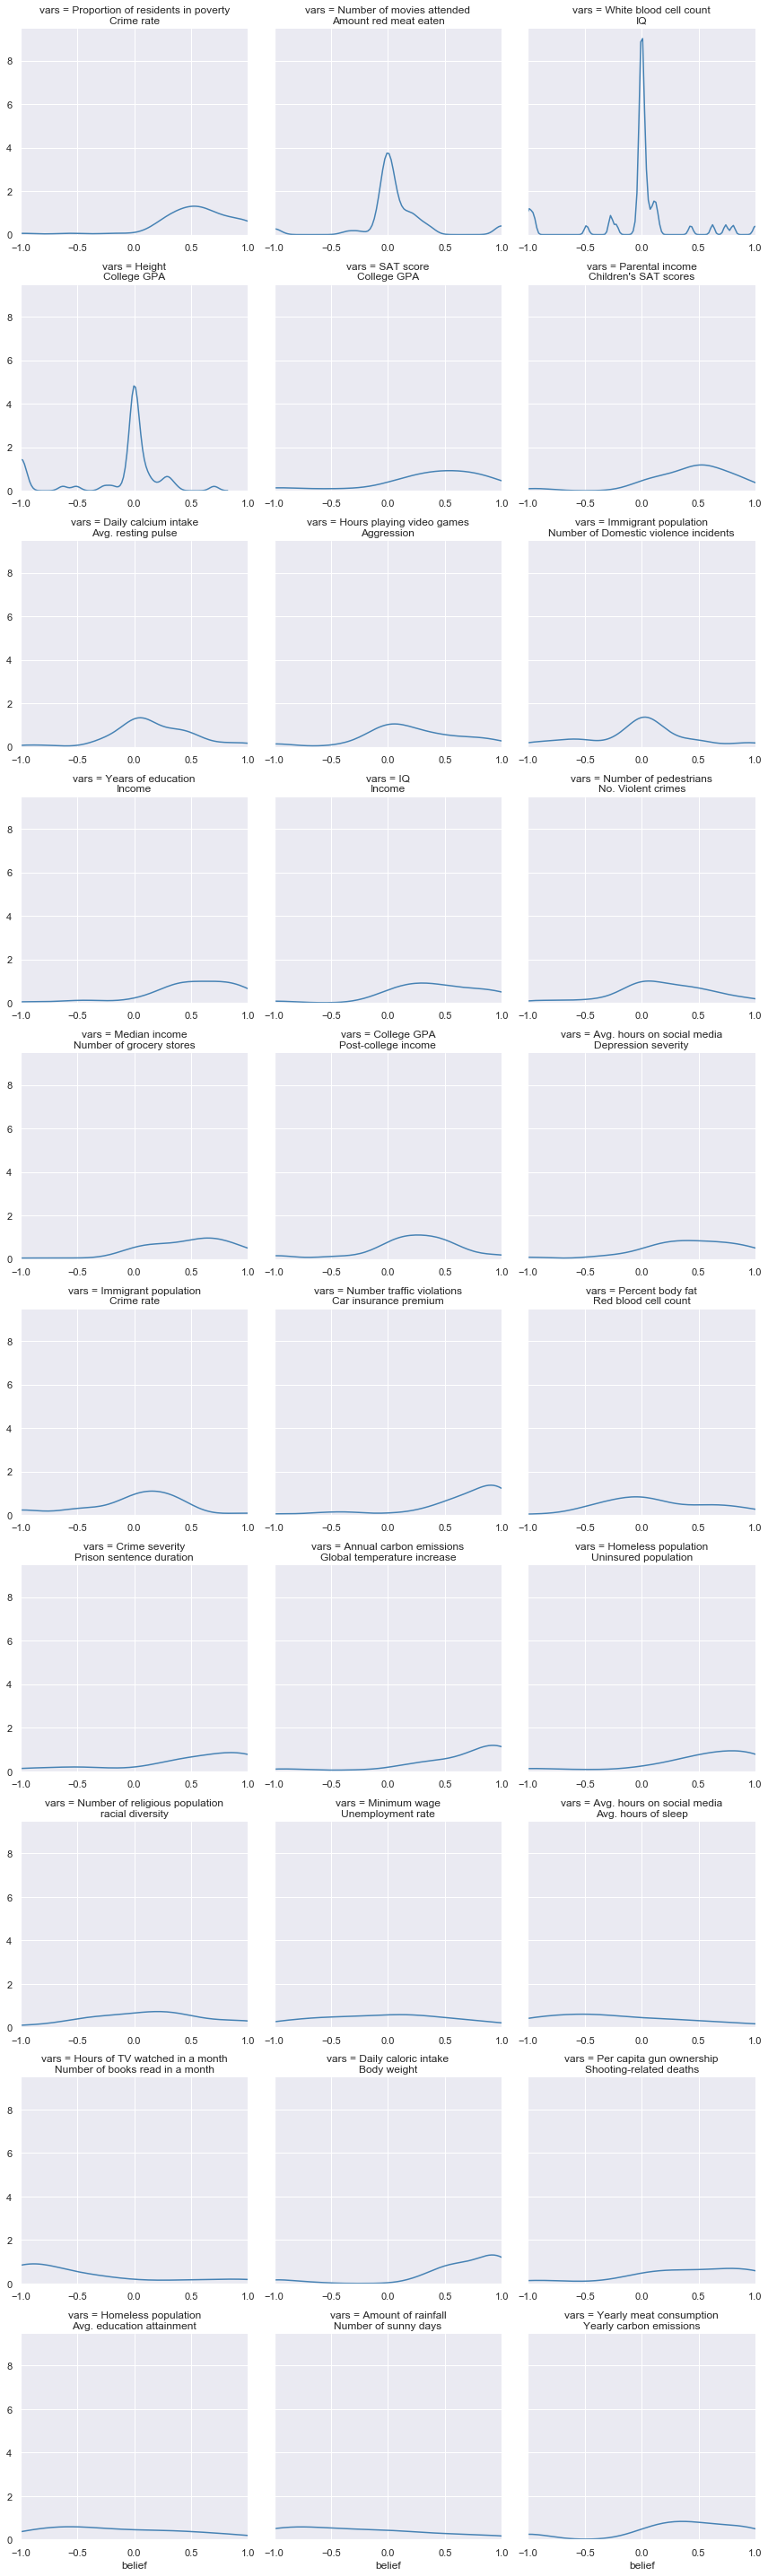

In [341]:
g = sns.FacetGrid(col="vars",col_wrap=3,data=df,height=4, aspect=1,sharey=True,sharex=False,xlim=[-1,1],col_order=agreement.index.values)
g.map(sns.kdeplot,"belief", color="steelblue")

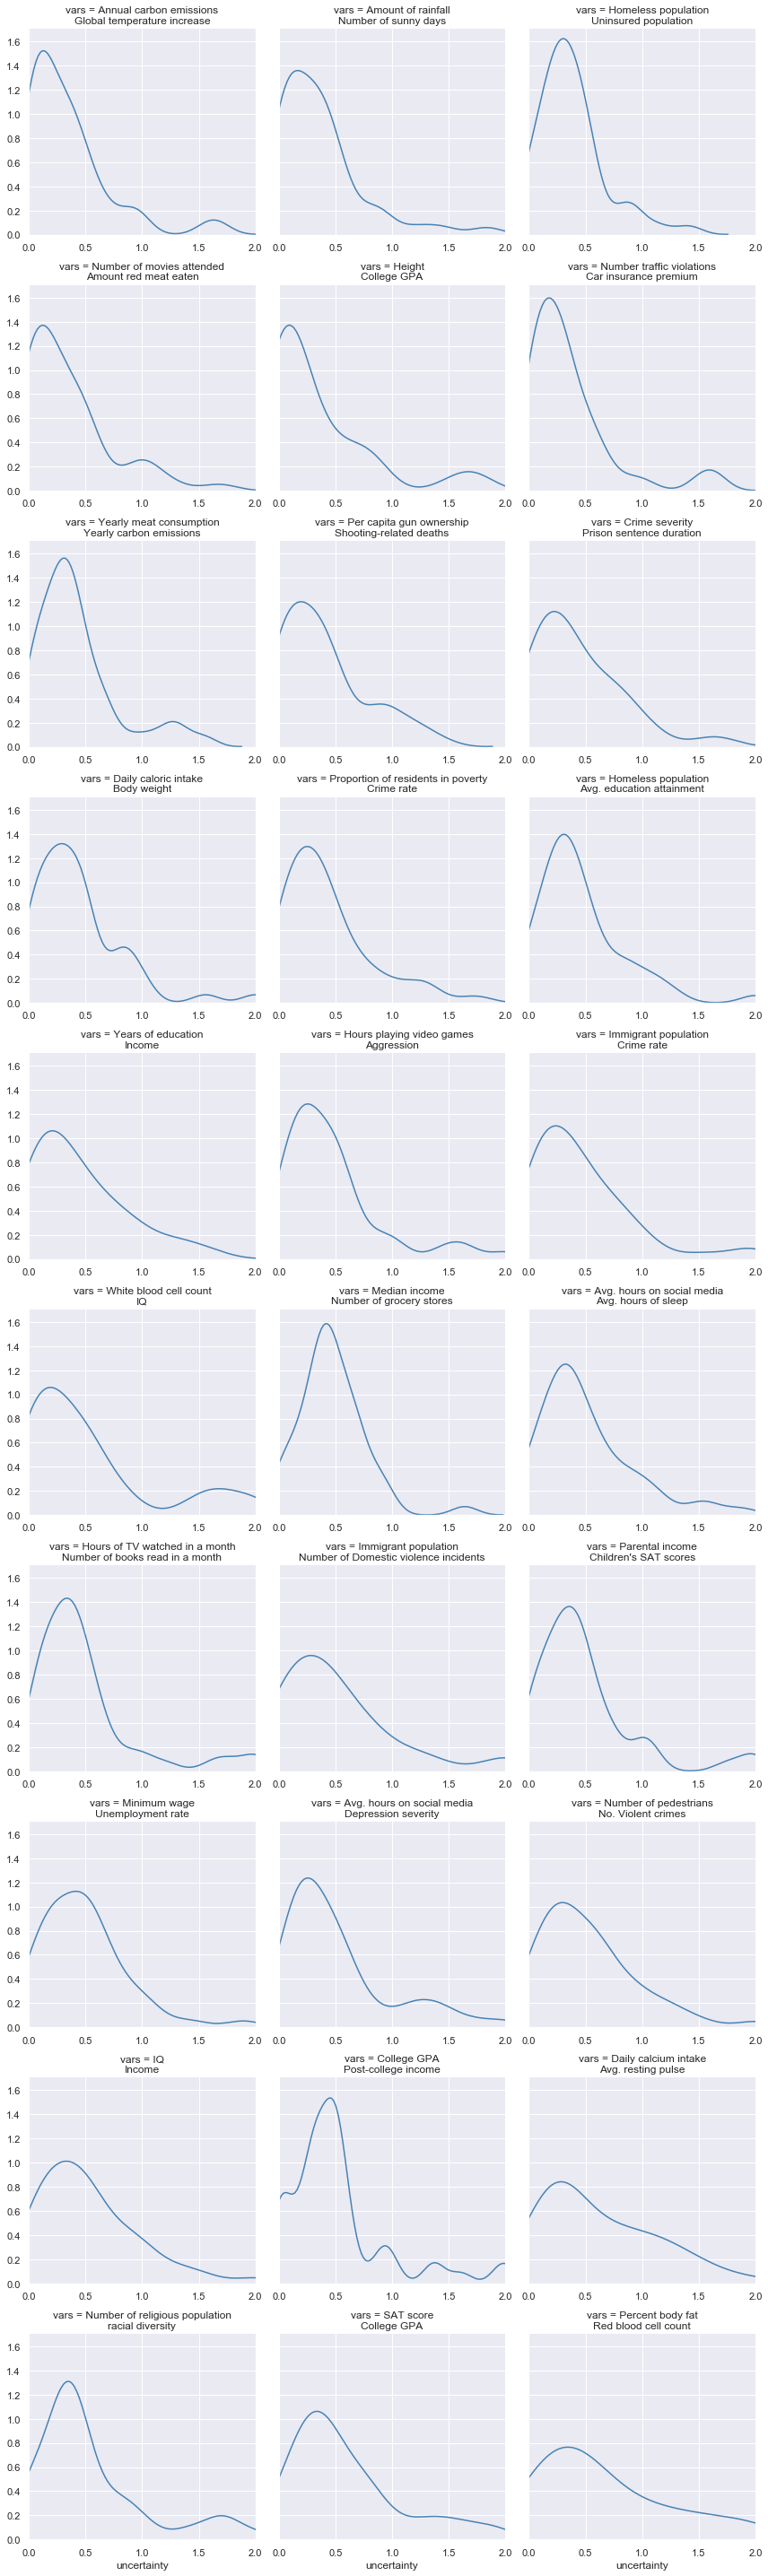

In [342]:
g = sns.FacetGrid(col="vars",col_wrap=3,data=df,height=4, aspect=1,sharey=True,sharex=False,xlim=[0,2],col_order=uncertainty.index.values)
g.map(sns.kdeplot, "uncertainty", color="steelblue")

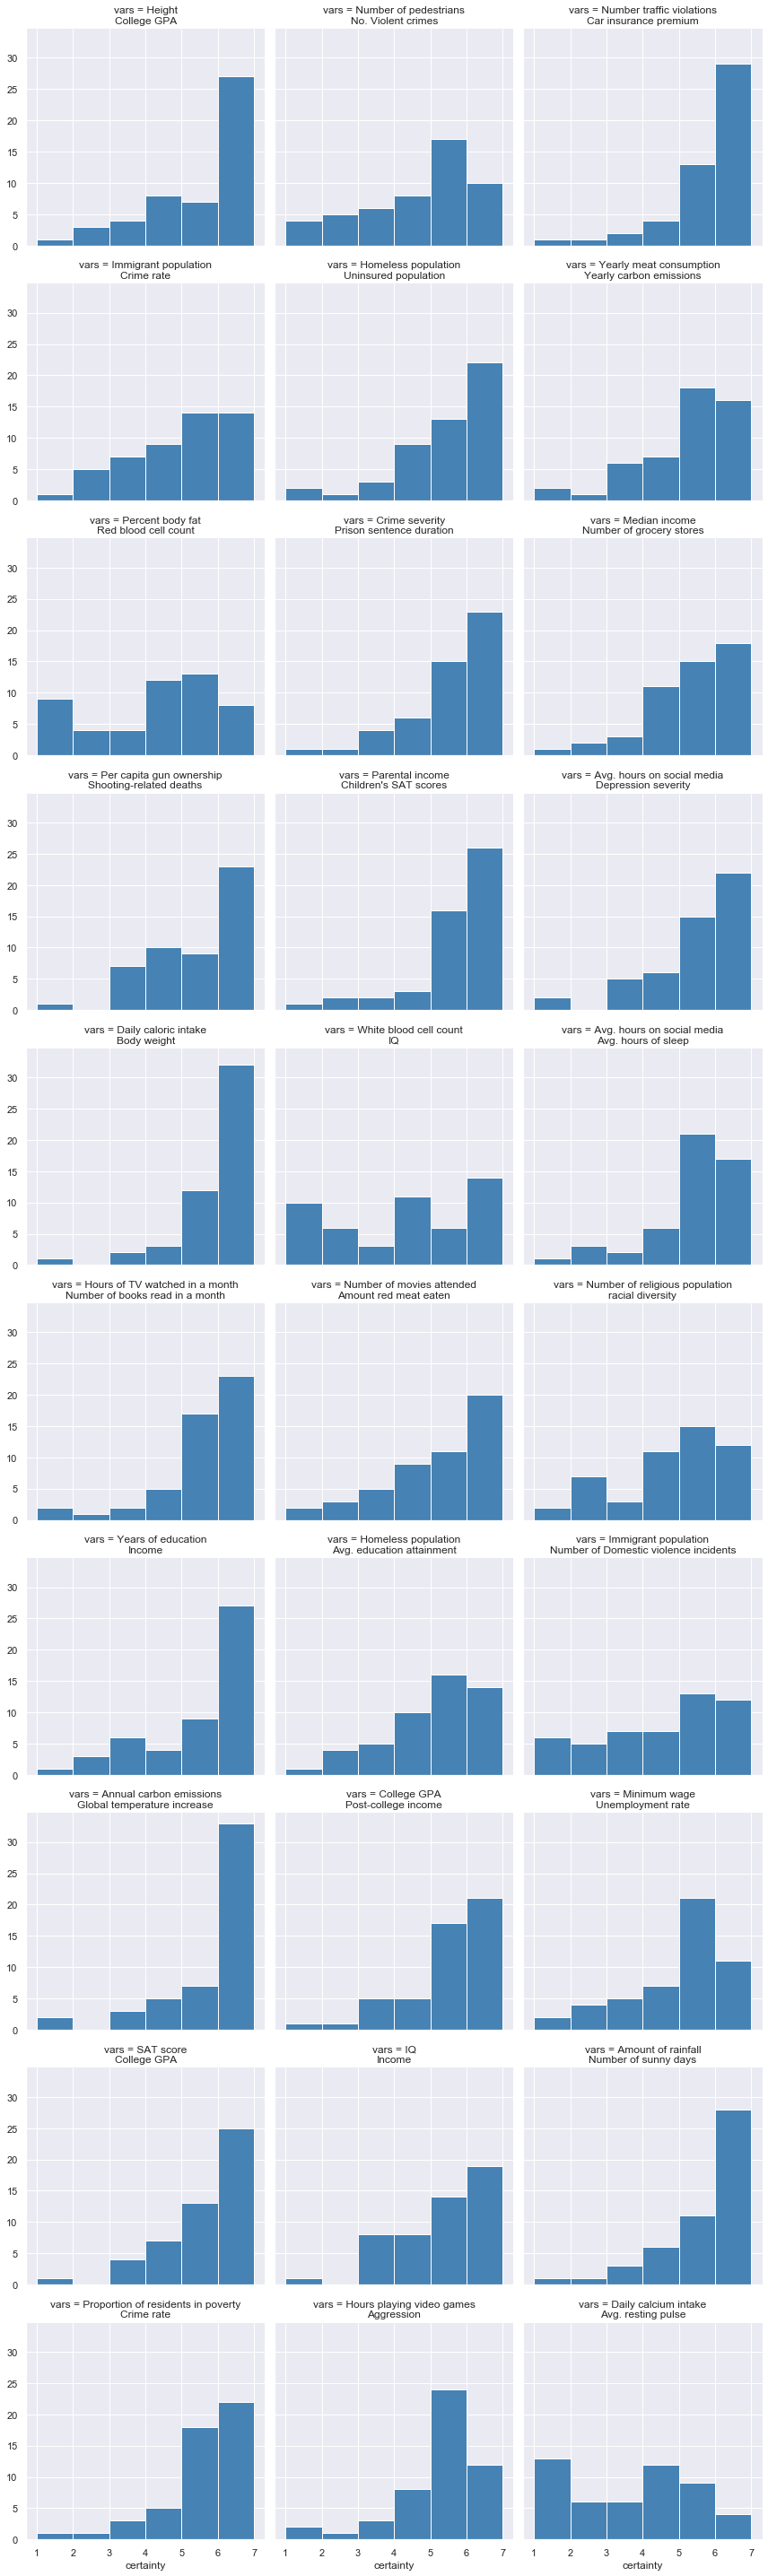

In [343]:
g = sns.FacetGrid(col="vars",col_wrap=3,data=df,height=4, aspect=1,sharey=True,sharex=True)
g.map(plt.hist, "certainty", color="steelblue",bins=[1,2,3,4,5,6,7])

In [344]:
df.to_csv("variableStudy.csv")

In [345]:
var_means = df.groupby('vars')["belief","uncertainty"].agg(["mean","std"],as_index=False)

In [346]:
agreement = belief_means.sort_values(["std"])

In [347]:
belief_std_median = np.median(var_means["belief","std"])
uncertainty_mean_median = np.median(var_means["uncertainty","mean"])

In [348]:
var_means["agreement"] = var_means["belief","std"].apply(lambda x: "high_agreement" if x<belief_std_median else "low_agreement")

In [349]:
var_means["confidence"] = var_means["uncertainty","mean"].apply(lambda x: "high_confidence" if x < uncertainty_mean_median else "low_confidence")

In [350]:
var_means

belief            \
                                                        mean       std   
vars                                                                     
Amount of rainfall\nNumber of sunny days           -0.279986  0.626831   
Annual carbon emissions\nGlobal temperature inc...  0.630553  0.503898   
Avg. hours on social media\nAvg. hours of sleep    -0.226687  0.599235   
Avg. hours on social media\nDepression severity     0.408708  0.459658   
College GPA\nPost-college income                    0.213901  0.443012   
Crime severity\nPrison sentence duration            0.471691  0.598644   
Daily calcium intake\nAvg. resting pulse            0.158822  0.374312   
Daily caloric intake\nBody weight                   0.627288  0.512798   
Height\nCollege GPA                                -0.137740  0.419974   
Homeless population\nAvg. education attainment     -0.152101  0.598066   
Homeless population\nUninsured population           0.515558  0.539520   
Hours of TV watched in a month\nNumber of books... -0.457820  0.659520   
Hours playing video games\nAggression               0.191294  0.459846   
IQ\nIncome                                          0.414241  0.438874   
Immigrant population\nCrime rate                   -0.011760  0.462682   
Immigrant population\nNumber of Domestic violen... -0.021457  0.464593   
Median income\nNumber of grocery stores             0.450278  0.406918   
Minimum wage\nUnemployment rate                    -0.037725  0.568491   
Number of movies attended\nAmount red meat eaten    0.062924  0.341984   
Number of pedestrians\nNo. Violent crimes           0.174166  0.430076   
Number of religious population\nracial diversity    0.149986  0.516375   
Number traffic violations\nCar insurance premium    0.629491  0.476872   
Parental income\nChildren's SAT scores              0.430425  0.391580   
Per capita gun ownership\nShooting-related deaths   0.392132  0.561821   
Percent body fat\nRed blood cell count              0.140085  0.465272   
Proportion of residents in poverty\nCrime rate      0.533132  0.376851   
SAT score\nCollege GPA                              0.371496  0.502231   
White blood cell count\nIQ                         -0.035526  0.403827   
Yearly meat consumption\nYearly carbon emissions    0.320607  0.579246   
Years of education\nIncome                          0.505276  0.425126   

                                                   uncertainty            \
                                                          mean       std   
vars                                                                       
Amount of rainfall\nNumber of sunny days              0.363923  0.378949   
Annual carbon emissions\nGlobal temperature inc...    0.340403  0.367782   
Avg. hours on social media\nAvg. hours of sleep       0.510563  0.415043   
Avg. hours on social media\nDepression severity       0.509567  0.469375   
College GPA\nPost-college income                      0.517333  0.463418   
Crime severity\nPrison sentence duration              0.434514  0.389187   
Daily calcium intake\nAvg. resting pulse              0.621472  0.496141   
Daily caloric intake\nBody weight                     0.434834  0.393046   
Height\nCollege GPA                                   0.355635  0.469827   
Homeless population\nAvg. education attainment        0.459852  0.384541   
Homeless population\nUninsured population             0.378974  0.293095   
Hours of TV watched in a month\nNumber of books...    0.497585  0.475385   
Hours playing video games\nAggression                 0.464013  0.439692   
IQ\nIncome                                            0.525415  0.433528   
Immigrant population\nCrime rate                      0.469070  0.450876   
Immigrant population\nNumber of Domestic violen...    0.521620  0.513315   
Median income\nNumber of grocery stores               0.466282  0.289906   
Minimum wage\nUnemployment rate                       0.483214  0.376444   
Number of movie

In [358]:
var_means.to_csv("var_means.csv")

In [352]:
var_means

belief            \
                                                        mean       std   
vars                                                                     
Amount of rainfall\nNumber of sunny days           -0.279986  0.626831   
Annual carbon emissions\nGlobal temperature inc...  0.630553  0.503898   
Avg. hours on social media\nAvg. hours of sleep    -0.226687  0.599235   
Avg. hours on social media\nDepression severity     0.408708  0.459658   
College GPA\nPost-college income                    0.213901  0.443012   
Crime severity\nPrison sentence duration            0.471691  0.598644   
Daily calcium intake\nAvg. resting pulse            0.158822  0.374312   
Daily caloric intake\nBody weight                   0.627288  0.512798   
Height\nCollege GPA                                -0.137740  0.419974   
Homeless population\nAvg. education attainment     -0.152101  0.598066   
Homeless population\nUninsured population           0.515558  0.539520   
Hours of TV watched in a month\nNumber of books... -0.457820  0.659520   
Hours playing video games\nAggression               0.191294  0.459846   
IQ\nIncome                                          0.414241  0.438874   
Immigrant population\nCrime rate                   -0.011760  0.462682   
Immigrant population\nNumber of Domestic violen... -0.021457  0.464593   
Median income\nNumber of grocery stores             0.450278  0.406918   
Minimum wage\nUnemployment rate                    -0.037725  0.568491   
Number of movies attended\nAmount red meat eaten    0.062924  0.341984   
Number of pedestrians\nNo. Violent crimes           0.174166  0.430076   
Number of religious population\nracial diversity    0.149986  0.516375   
Number traffic violations\nCar insurance premium    0.629491  0.476872   
Parental income\nChildren's SAT scores              0.430425  0.391580   
Per capita gun ownership\nShooting-related deaths   0.392132  0.561821   
Percent body fat\nRed blood cell count              0.140085  0.465272   
Proportion of residents in poverty\nCrime rate      0.533132  0.376851   
SAT score\nCollege GPA                              0.371496  0.502231   
White blood cell count\nIQ                         -0.035526  0.403827   
Yearly meat consumption\nYearly carbon emissions    0.320607  0.579246   
Years of education\nIncome                          0.505276  0.425126   

                                                   uncertainty            \
                                                          mean       std   
vars                                                                       
Amount of rainfall\nNumber of sunny days              0.363923  0.378949   
Annual carbon emissions\nGlobal temperature inc...    0.340403  0.367782   
Avg. hours on social media\nAvg. hours of sleep       0.510563  0.415043   
Avg. hours on social media\nDepression severity       0.509567  0.469375   
College GPA\nPost-college income                      0.517333  0.463418   
Crime severity\nPrison sentence duration              0.434514  0.389187   
Daily calcium intake\nAvg. resting pulse              0.621472  0.496141   
Daily caloric intake\nBody weight                     0.434834  0.393046   
Height\nCollege GPA                                   0.355635  0.469827   
Homeless population\nAvg. education attainment        0.459852  0.384541   
Homeless population\nUninsured population             0.378974  0.293095   
Hours of TV watched in a month\nNumber of books...    0.497585  0.475385   
Hours playing video games\nAggression                 0.464013  0.439692   
IQ\nIncome                                            0.525415  0.433528   
Immigrant population\nCrime rate                      0.469070  0.450876   
Immigrant population\nNumber of Domestic violen...    0.521620  0.513315   
Median income\nNumber of grocery stores               0.466282  0.289906   
Minimum wage\nUnemployment rate                       0.483214  0.376444   
Number of movie

In [353]:
var_means.groupby(["agreement","confidence"]).count()

belief     uncertainty    
                                 mean std        mean std
agreement      confidence                                
high_agreement high_confidence      6   6           6   6
               low_confidence       9   9           9   9
low_agreement  high_confidence      9   9           9   9
               low_confidence       6   6           6   6

In [357]:
len(df["user"].unique())

50

In [374]:
with open('final_variables.json') as jsonFile:
    tData = json.loads(jsonFile.read())

In [375]:
for t in tData:
    tSplit = t["vars"].split("\n ")
    unit = varUnitMap.get(tuple(tSplit))
    var = [tSplit,unit]
    t["varString"] = t["vars"]
    t["vars"] = var
    t["congruent"] = True if t["congruency"] == "congruent" else False

In [365]:
varUnitMap = {tuple(var[0]): var[1] for var in docs[0]["variables"]}


In [366]:
varUnitMap

{('Height', 'College GPA'): 'People',
 ('Number of pedestrians', 'No. Violent crimes'): 'Cities',
 ('Number traffic violations', 'Car insurance premium'): 'People',
 ('Immigrant population', 'Crime rate'): 'Countries',
 ('Homeless population', 'Uninsured population'): 'Countries',
 ('Yearly meat consumption', 'Yearly carbon emissions'): 'Countries',
 ('Percent body fat', 'Red blood cell count'): 'People',
 ('Crime severity', 'Prison sentence duration'): 'People',
 ('Median income', 'Number of grocery stores'): 'Cities',
 ('Per capita gun ownership', 'Shooting-related deaths'): 'Country',
 ('Parental income', "Children's SAT scores"): 'Household',
 ('Avg. hours on social media', 'Depression severity'): 'People',
 ('Daily caloric intake', 'Body weight'): 'People',
 ('White blood cell count', 'IQ'): 'People',
 ('Avg. hours on social media', 'Avg. hours of sleep'): 'People',
 ('Hours of TV watched in a month',
  'Number of books read in a month'): 'People',
 ('Number of movies attended', '

In [377]:
with open("finalVariables.json","w") as jsonFile:
    jsonFile.write(json.dumps(tData))